# Brain Tumor MRI—Classification

## Import Libraries, Preferences, and Helper Functions

### Libraries

In [1]:
# System
import warnings

# Data manipulation
import pandas as pd
import numpy as np

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Class weight calculation
from sklearn.utils.class_weight import compute_class_weight

# Machine learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import VGG16, MobileNetV2, DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras import regularizers

### Prefences

In [2]:
EPOCHS = 2
NUM_GPUS = 2
BATCH_SIZE = 48
IMAGE_HEIGHT, IMAGE_WIDTH = 299, 299

# Suppress warnings
warnings.filterwarnings('ignore')

# Set the default Seaborn style
sns.set_theme(style='whitegrid', font='serif')

### Helper Functions

#### Data Generators

In [3]:
"""
Data augmentation and preprocessing
- `rescale`: Rescale pixel values to the range [0, 1]
- `rotation_range`: Degree range for random rotations 
- `width_shift_range`: Fraction of total width for horizontal random shift
- `height_shift_range`: Fraction of total height for vertical random shift
- `shear_range`: Shear intensity (shear angle in counter-clockwise direction in degrees)
- `zoom_range`: Range for random zoom
- `brightness_range`: Range for random brightness
- `horizontal_flip`: Randomly flip inputs horizontally
- `vertical_flip`: Randomly flip inputs vertically
- `fill_mode`: Points outside the boundaries of the input are filled according to the given mode
"""
train_datagen_1 = ImageDataGenerator(
  rescale=1./255,
  rotation_range=5,
  width_shift_range=0.05,
  height_shift_range=0.05,
  shear_range=0.05,
  zoom_range=0.05,
  brightness_range=[0.95, 1.05],
  horizontal_flip=False,
  vertical_flip=False,
  fill_mode='nearest',
)

train_datagen_2 = ImageDataGenerator(
  rescale=1./255,
  rotation_range=10,
  width_shift_range=0.1,
  height_shift_range=0.1,
  shear_range=0.1,
  zoom_range=0.1,
  brightness_range=[0.9, 1.1],
  horizontal_flip=False,
  vertical_flip=False,
  fill_mode='nearest',
)

train_datagen_3 = ImageDataGenerator(
  rescale=1./255
)

## Load the Data

In [4]:
train_dataset_1 = train_datagen_1.flow_from_directory(
  directory='../datasets/raw/training',
  color_mode='rgb',
  target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
  batch_size=BATCH_SIZE,
  class_mode='categorical',
  shuffle=True,
  seed=42
)

Found 2870 images belonging to 4 classes.


In [5]:
test_dataset_1 = train_datagen_3.flow_from_directory(
  directory='../datasets/raw/testing',
  color_mode='rgb',
  target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
  batch_size=BATCH_SIZE,
  class_mode='categorical',
  shuffle=True,
  seed=42
)

Found 394 images belonging to 4 classes.


## Explorative Data Analysis

In [6]:
class_weights = compute_class_weight(
  class_weight='balanced',
  classes=np.unique(train_dataset_1.classes),
  y=train_dataset_1.classes
)

class_weights = dict(enumerate(class_weights))

# Preview the class weights
class_weights

{0: 0.8686440677966102,
 1: 0.8728710462287105,
 2: 1.8164556962025316,
 3: 0.8675937122128174}

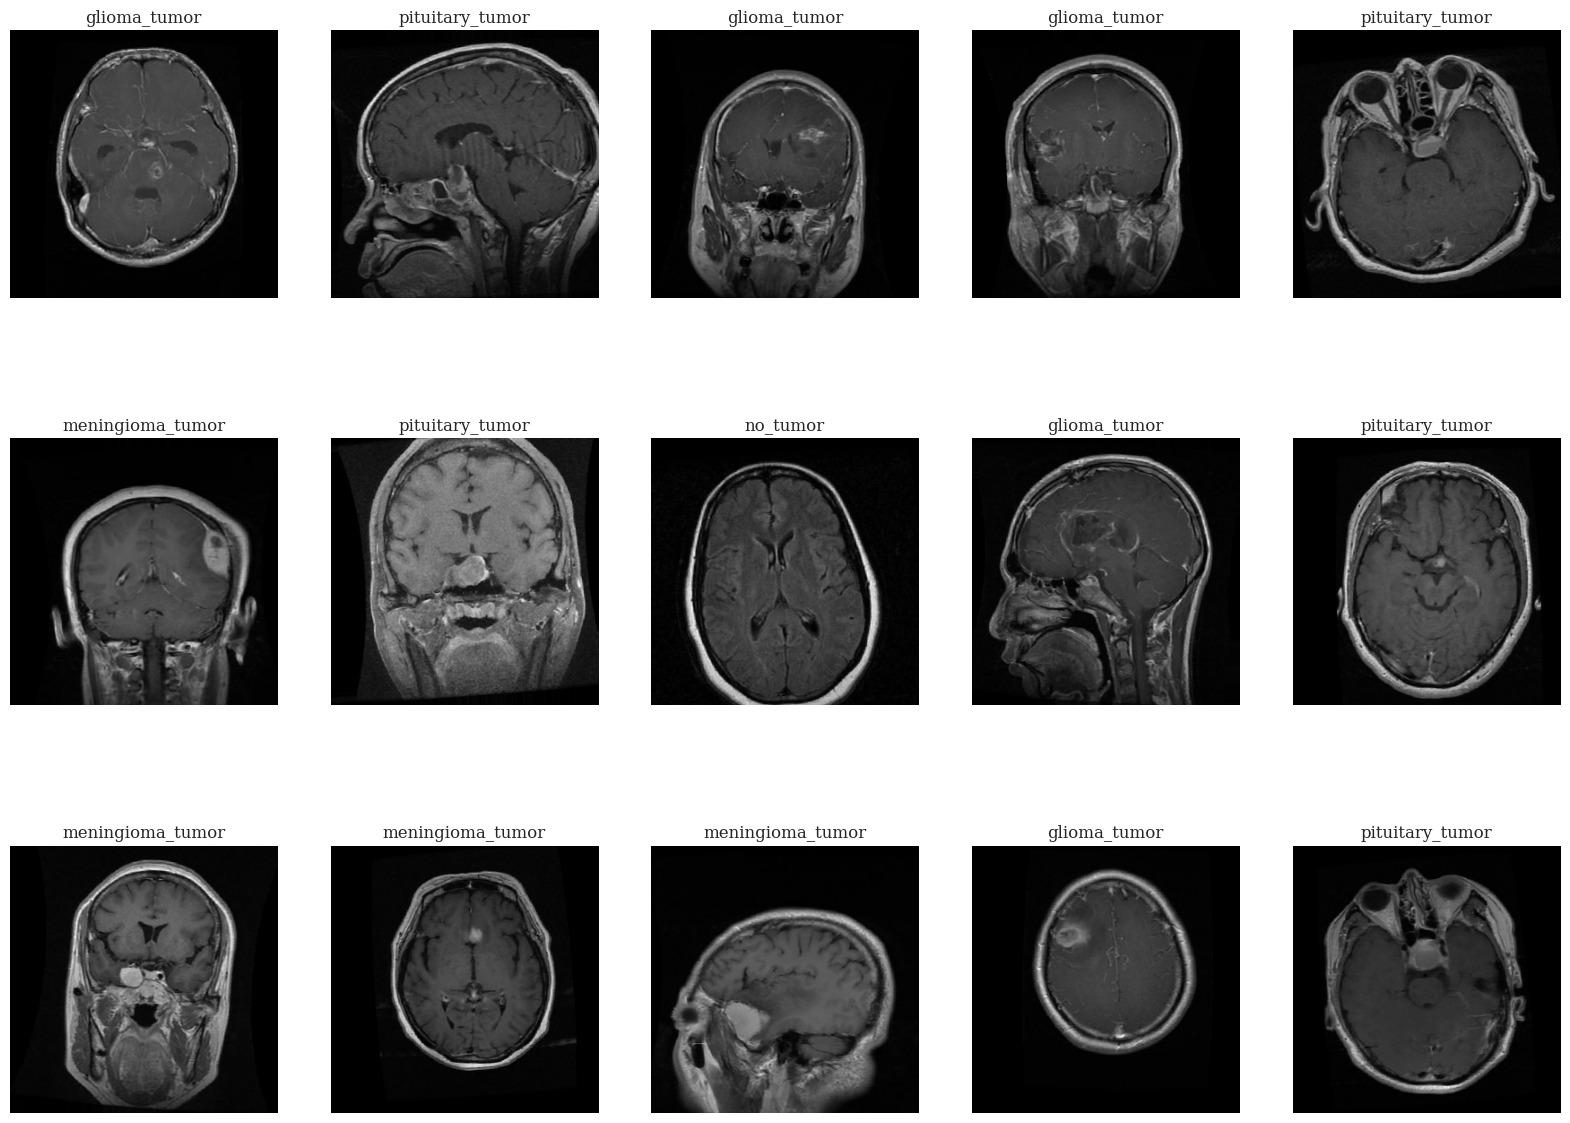

In [7]:
classes = train_dataset_1.class_indices
class_names = list(classes.keys())

# Get the next batch of images and labels
img, label = next(train_dataset_1)

# Set the figure size
plt.figure(figsize=(20, 15))

# Plot sample images
for i in range(15):
  plt.subplot(3, 5, i + 1)
  plt.imshow(img[i])
  plt.axis('off')
  plt.title(class_names[np.argmax(label[i])])

# Display the plot
plt.show()

## Model Building

### Convolutional Neural Networks

In [8]:
# Early stopping callback
early_stopping = EarlyStopping(
  monitor='val_accuracy',
  patience=2,
  verbose=1,
  restore_best_weights=True
)

# Reduce learning rate on plateau callback
reduce_lr_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(
  monitor='val_accuracy',
  factor=0.001,
  patience=10,
  verbose=1,
  min_lr=1e-5
)

### VGG16

In [9]:
# Initialize Mirrored Strategy
strategy = tf.distribute.MirroredStrategy()

# Open a strategy scope
with strategy.scope():
  # Load the VGG16 base model
  VGG16_base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3)
  )

  # Set the layer to non-train
  for layer in VGG16_base_model.layers:
    layer.trainable = False

  # Initialize the model
  VGG16_model = Sequential()
  VGG16_model.add(VGG16_base_model)

  # Add connected layers and output layer
  VGG16_model.add(GlobalAveragePooling2D())
  VGG16_model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
  VGG16_model.add(Dropout(0.4))
  VGG16_model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
  VGG16_model.add(Dropout(0.2))
  VGG16_model.add(Dense(4, activation='softmax'))

  # Compile the model
  VGG16_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

  # Fit the model
  VGG16_history = VGG16_model.fit(
    train_dataset_1, 
    epochs=EPOCHS,
    validation_data=test_dataset_1,
    class_weight=class_weights,
    callbacks=[early_stopping],
  )

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)

Epoch 1/2
60/60 ━━━━━━━━━━━━━━━━━━━━ 516s 9s/step - accuracy: 0.2961 - loss: 1.6339 - val_accuracy: 0.3706 - val_loss: 1.5674
Epoch 2/2
60/60 ━━━━━━━━━━━━━━━━━━━━ 506s 8s/step - accuracy: 0.5001 - loss: 1.2606 - val_accuracy: 0.3782 - val_loss: 1.5714
Restoring model weights from the end of the best epoch: 2.


In [10]:
# Preview model summary
VGG16_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 9, 9, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,937,230 (56.98 MB)

 Trainable params: 74,180 (289.77 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 148,362 (579.54 KB)

In [11]:
# Validation accuracy
VGG16_val_loss, VGG16_val_accuracy = VGG16_model.evaluate(test_dataset_1, steps=len(test_dataset_1))
print('[VALIDATION]')
print(f'Accuracy: {VGG16_val_accuracy * 100:.2f}%')
print(f'Loss: {VGG16_val_loss:.2f}\n')

# Training accuracy
VGG16_train_loss, VGG16_train_accuracy = VGG16_model.evaluate(train_dataset_1, steps=len(train_dataset_1))
print('[TRAINING]')
print(f'Accuracy: {VGG16_train_accuracy * 100:.2f}%')
print(f'Loss: {VGG16_train_loss:.2f}')

9/9 ━━━━━━━━━━━━━━━━━━━━ 61s 7s/step - accuracy: 0.3509 - loss: 1.6202
VALIDATION

Accuracy: 37.82%
Loss: 1.57
60/60 ━━━━━━━━━━━━━━━━━━━━ 441s 7s/step - accuracy: 0.6426 - loss: 1.0316

TRAINING

Accuracy: 65.44%
Loss: 1.02


#### Visualize the Model

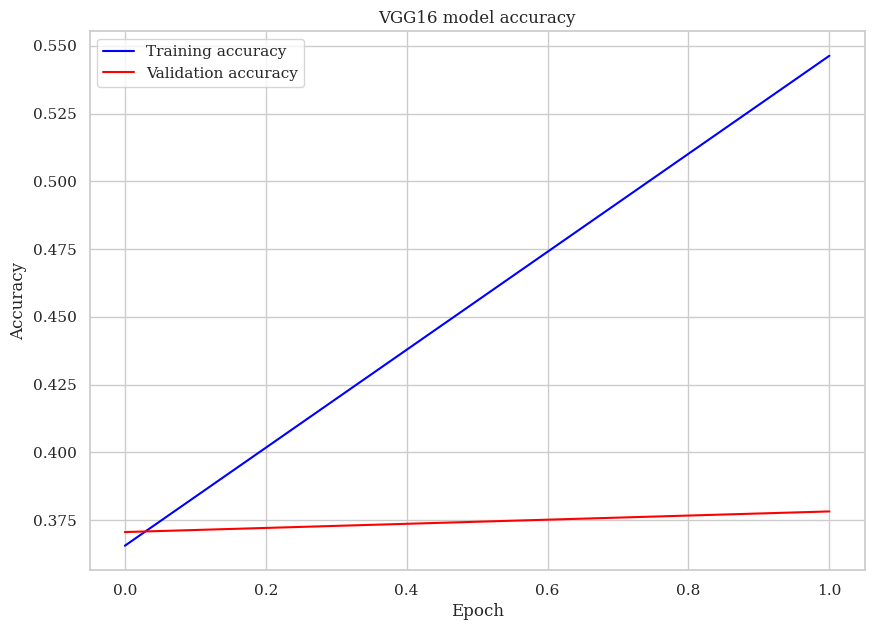

In [12]:
# Set the figure size
plt.figure(figsize=(10, 7))

# Plot training and validation accuracy
plt.plot(VGG16_history.history['accuracy'], label='Training accuracy', color='blue')
plt.plot(VGG16_history.history['val_accuracy'], label='Validation accuracy', color='red')

# Add title and labels
plt.title('VGG16 model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Display the legend
plt.legend()

# Display the plot
plt.show()

### MobileNetV2

In [13]:
# Initialize Mirrored Strategy
strategy = tf.distribute.MirroredStrategy()

# Open a strategy scope
with strategy.scope():
  # Load the MobileNetV2 base model
  MobileNetV2_base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3)
  )

  # Set the layer to non-train
  for layer in MobileNetV2_base_model.layers:
    layer.trainable = False

  # Initialize the model
  MobileNetV2_model = Sequential()
  MobileNetV2_model.add(MobileNetV2_base_model)

  # Add connected layers and output layer
  MobileNetV2_model.add(GlobalAveragePooling2D())
  MobileNetV2_model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
  MobileNetV2_model.add(Dropout(0.4))
  MobileNetV2_model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
  MobileNetV2_model.add(Dropout(0.2))
  MobileNetV2_model.add(Dense(4, activation='softmax'))

  # Compile the model
  MobileNetV2_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

  # Fit the model
  MobileNetV2_history = MobileNetV2_model.fit(
    train_dataset_1, 
    epochs=EPOCHS,
    validation_data=test_dataset_1,
    class_weight=class_weights,
    callbacks=[early_stopping],
  )

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Epoch 1/2
60/60 ━━━━━━━━━━━━━━━━━━━━ 138s 2s/step - accuracy: 0.4834 - loss: 1.4320 - val_accuracy: 0.4036 - val_loss: 2.2731
Epoch 2/2
60/60 ━━━━━━━━━━━━━━━━━━━━ 133s 2s/step - accuracy: 0.7601 - loss: 0.8769 - val_accuracy: 0.4670 - val_loss: 1.8845
Restoring model weights from the end of the best epoch: 2.


In [14]:
# Preview model summary
MobileNetV2_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 10, 10, 1280)   │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,775,438 (10.59 MB)

 Trainable params: 172,484 (673.77 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 344,970 (1.32 MB)

In [15]:
# Validation accuracy
MobileNetV2_val_loss, MobileNetV2_val_accuracy = MobileNetV2_model.evaluate(test_dataset_1, steps=len(test_dataset_1))
print('[VALIDATION]')
print(f'Accuracy: {MobileNetV2_val_accuracy * 100:.2f}%')
print(f'Loss: {MobileNetV2_val_loss:.2f}\n')

# Training accuracy
MobileNetV2_train_loss, MobileNetV2_train_accuracy = MobileNetV2_model.evaluate(train_dataset_1, steps=len(train_dataset_1))
print('[TRAINING]')
print(f'Accuracy: {MobileNetV2_train_accuracy * 100:.2f}%')
print(f'Loss: {MobileNetV2_train_loss:.2f}')

9/9 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.4456 - loss: 1.9787
VALIDATION

Accuracy: 46.70%
Loss: 1.88
60/60 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - accuracy: 0.8575 - loss: 0.6329

TRAINING

Accuracy: 84.56%
Loss: 0.65


#### Visualize the Model

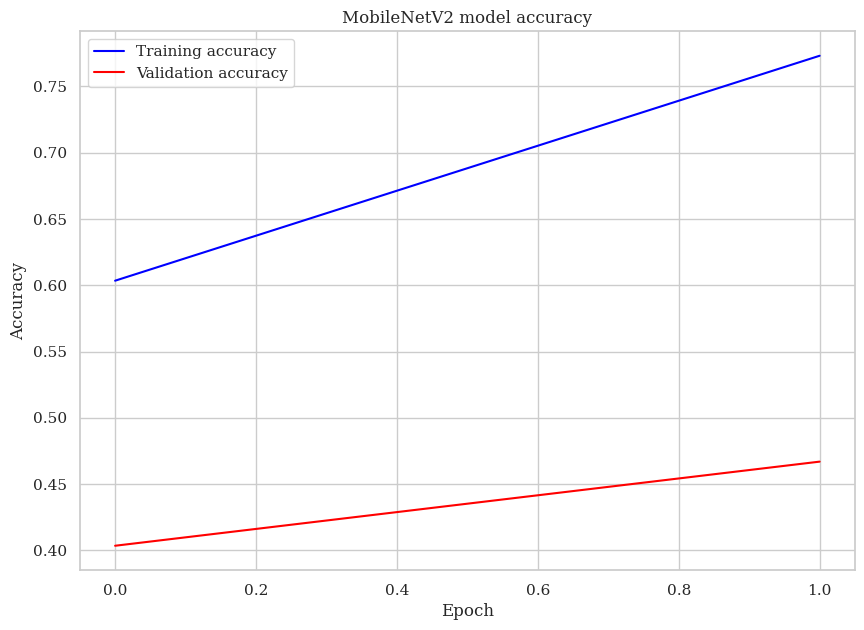

In [16]:
# Set the figure size
plt.figure(figsize=(10, 7))

# Plot training and validation accuracy
plt.plot(MobileNetV2_history.history['accuracy'], label='Training accuracy', color='blue')
plt.plot(MobileNetV2_history.history['val_accuracy'], label='Validation accuracy', color='red')

# Add title and labels
plt.title('MobileNetV2 model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Display the legend
plt.legend()

# Display the plot
plt.show()

### DenseNet121

In [17]:
# Initialize Mirrored Strategy
strategy = tf.distribute.MirroredStrategy()

# Open a strategy scope
with strategy.scope():
  # Load the DenseNet121 base model
  DenseNet121_base_model = DenseNet121(
    weights='imagenet',
    include_top=False,
    input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3)
  )

  # Set the layer to non-train
  for layer in DenseNet121_base_model.layers:
    layer.trainable = False

  # Initialize the model
  DenseNet121_model = Sequential()
  DenseNet121_model.add(DenseNet121_base_model)

  # Add connected layers and output layer
  DenseNet121_model.add(GlobalAveragePooling2D())
  DenseNet121_model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
  DenseNet121_model.add(Dropout(0.4))
  DenseNet121_model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
  DenseNet121_model.add(Dropout(0.2))
  DenseNet121_model.add(Dense(4, activation='softmax'))

  # Compile the model
  DenseNet121_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

  # Fit the model
  DenseNet121_history = DenseNet121_model.fit(
    train_dataset_1, 
    epochs=EPOCHS,
    validation_data=test_dataset_1,
    class_weight=class_weights,
    callbacks=[early_stopping],
  )

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Epoch 1/2
60/60 ━━━━━━━━━━━━━━━━━━━━ 274s 4s/step - accuracy: 0.4251 - loss: 1.5686 - val_accuracy: 0.4365 - val_loss: 1.6579
Epoch 2/2
60/60 ━━━━━━━━━━━━━━━━━━━━ 259s 4s/step - accuracy: 0.7287 - loss: 0.8765 - val_accuracy: 0.4721 - val_loss: 1.7967
Restoring model weights from the end of the best epoch: 2.


In [18]:
# Preview model summary
DenseNet121_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 9, 9, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,456,654 (28.44 MB)

 Trainable params: 139,716 (545.77 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

 Optimizer params: 279,434 (1.07 MB)

In [19]:
# Validation accuracy
DenseNet121_val_loss, DenseNet121_val_accuracy = DenseNet121_model.evaluate(test_dataset_1, steps=len(test_dataset_1))
print('VALIDATION')
print(f'Accuracy: {DenseNet121_val_accuracy * 100:.2f}%')
print(f'Loss: {DenseNet121_val_loss:.2f}\n')

# Training accuracy
DenseNet121_train_loss, DenseNet121_train_accuracy = DenseNet121_model.evaluate(train_dataset_1, steps=len(train_dataset_1))
print('TRAINING')
print(f'Accuracy: {DenseNet121_train_accuracy * 100:.2f}%')
print(f'Loss: {DenseNet121_train_loss:.2f}')

9/9 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step - accuracy: 0.4908 - loss: 1.7621
VALIDATION

Accuracy: 47.21%
Loss: 1.80
60/60 ━━━━━━━━━━━━━━━━━━━━ 230s 4s/step - accuracy: 0.8343 - loss: 0.6156

TRAINING

Accuracy: 83.10%
Loss: 0.62


#### Visualize the Model

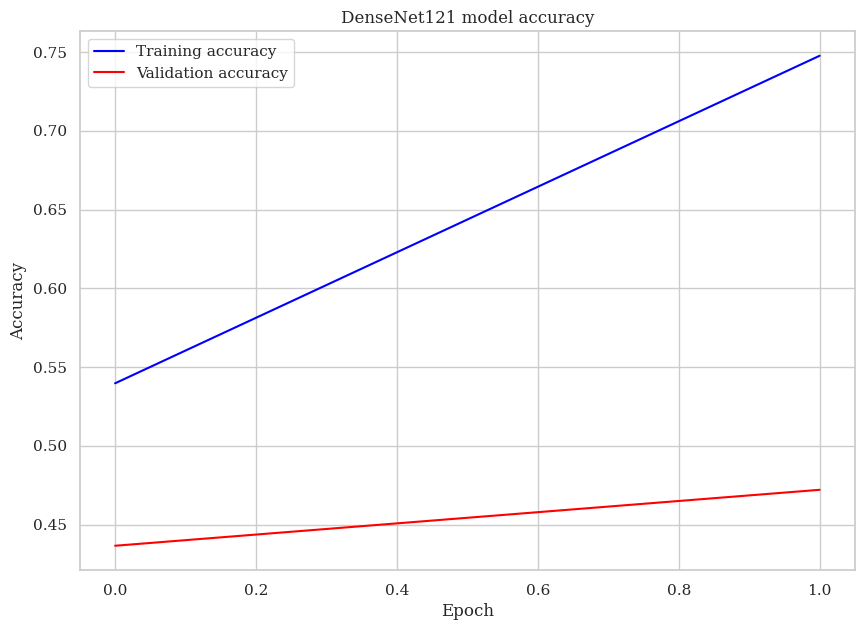

In [20]:
# Set the figure size
plt.figure(figsize=(10, 7))

# Plot training and validation accuracy
plt.plot(DenseNet121_history.history['accuracy'], label='Training accuracy', color='blue')
plt.plot(DenseNet121_history.history['val_accuracy'], label='Validation accuracy', color='red')

# Add title and labels
plt.title('DenseNet121 model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Display the legend
plt.legend()

# Display the plot
plt.show()